In [1]:
from matplotlib import pyplot as plt
from scipy import signal
import numpy as np
import random
%matplotlib inline

In [2]:
shape=(20,30)

In [25]:
class Nibbles:
    def __init__(self, shape):
        self.shape = shape
        self.radius = None
        self.reset()
        
    def reset(self):
        self.head = (int(shape[0]/2), int(shape[1]/2))
        self.tail = [(int(shape[0]/2), int(shape[1]/2)-1), (int(shape[0]/2), int(shape[1]/2))]
        self.direction = (0, 1)
        self.grow = 0
        
        self.board = np.zeros(self.shape + (3,))
        self.build_walls()
        self.draw_tail()
        self.generate_food()
        
    def set_food_radius(self, radius):
        self.radius = radius
        
    def generate_food(self):
        self.board[:,:,2] = np.zeros(self.shape)
        while True:
            if self.radius:
                self.food = (self.head[0] + random.randint(-radius,radius), self.head[1] + random.randint(-radius, radius))
            else:
                self.food = (random.randint(0,shape[0]-1), random.randint(0,shape[1]-1))
                
            if self.valid_index(self.food) and np.amax(self.board, axis=2)[self.food] == 0:
                self.board[:,:,2][self.food] = 1
                return
            
    def valid_index(self, index):
        return index[0] >= 0 and index[0] < self.shape[0] and index[1] >= 0 and index[1] < self.shape[1]
        
    def draw_tail(self):
        self.board[:,:,1] = np.zeros(self.shape)
        for pixel in self.tail:
            self.board[:,:,1][pixel] = 0.5
        
        self.board[:,:,1][self.tail[-1]] = 1
        
    def build_walls(self):
        self.board[0,:,0] = 1
        self.board[-1,:,0] = 1
        self.board[:,0,0] = 1
        self.board[:,-1,0] = 1
        
        #self.board[int(shape[0]/3),int(shape[1]/4):int(3*shape[1]/4),0] = 1
        #self.board[int(2*shape[0]/3),int(shape[1]/4):int(3*shape[1]/4),0] = 1 
    
    def list_actions(self):
        return [(0,1),(1,0),(0,-1),(-1,0)]
    
    def next(self, direction):
        if(not np.any(np.array(direction) + np.array(self.direction))):
            return [0, False]
        
        self.direction = direction
            
        self.head = tuple(np.array(self.head) + np.array(self.direction))
        
        revard = 1
        game_over = False
        
        if self.head == self.food: 
            revard += 1000
            self.grow = 5
            self.generate_food()
        
        if self.board[:,:,0][self.head] > 0:
            game_over = True
            revard = -1000
            
        if self.board[:,:,1][self.head] > 0:
            game_over = True
            revard = -1000
        
        if self.grow > 0:
            self.grow -= 1
        else:
            self.tail.pop(0)
            
        self.tail.append(self.head)
        self.draw_tail()
        
        return [revard, game_over]
        
    def get_board(self):
        return self.board
    


In [4]:
from IPython.core.display import display as core_display
from IPython.core.display import HTML 

def next(direction):
    revard, game_over = nibbles.next(direction)
    if game_over:
        nibbles.reset()

nibbles = Nibbles(shape)

html = """

<div id='display_div'></div>
<button onclick='step("(0,-1)")'>🡸</button>
<button onclick='step("(-1,0)")'>🡹</button>
<button onclick='step("(1,0)")'>🡻</button>
<button onclick='step("(0,1)")'>🡺</button>

<script type="text/Javascript">
    var kernel = IPython.notebook.kernel;
    
    function display_state(out) {
        document.getElementById('display_div').innerHTML = '<img src="data:image/png;base64,'+out.content.data['image/png']+'">'
    }
    
    function step(direction) {
        kernel.execute('next('+direction+')');
        draw()
    }
    
    function draw() {    
        kernel.execute('plt.imshow(nibbles.get_board())', {"iopub" : {"output":display_state}});
    }
    
    draw()
</script>
"""
core_display(HTML(html))

# Deep Q Learn

In [5]:
from keras.models import Sequential
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.layers.core import Flatten, Dense

from IPython import display

Using TensorFlow backend.


In [6]:
hidden_layer_count = 20

In [7]:
model = Sequential([
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu', input_shape=nibbles.get_board().shape),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (5,5), padding='same', activation='relu', strides=(2,2)),
    BatchNormalization(axis=3),
    Conv2D(hidden_layer_count*2, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count*2, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count*2, (5,5), padding='same', activation='relu', strides=(2,2)),
    BatchNormalization(axis=3),
    Conv2D(hidden_layer_count*4, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count*4, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count*4, (5,5), padding='same', activation='relu', strides=(2,2)),
    BatchNormalization(axis=3),
    Flatten(),
    Dense(hidden_layer_count*6, activation='relu'),
    Dense(hidden_layer_count*3, activation='relu'),
    Dense(hidden_layer_count, activation='relu'),
    Dense(4)
])

opt = Nadam(lr=1e-3)
model.compile(optimizer=opt, loss='mean_squared_error')

In [8]:
experiences = []

In [26]:
epsilon = 0.3
discount = 0.90
radius = 1

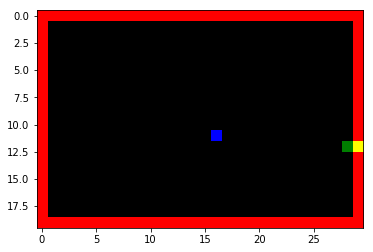

12 24 -981 16223.5 ( 26470 ) 1 0.3


KeyboardInterrupt: 

In [28]:


for i in range(1000000):
    nibbles.reset()
    nibbles.set_food_radius(radius)
    game_length = 0
    total_revard = 0
    game_over = False
    while not game_over:
        if np.random.rand() < epsilon:
            action_index = random.randint(0,3)
        else: 
            q = np.squeeze(model.predict(np.expand_dims(nibbles.get_board(), axis=0)))
            action_index = sorted(range(4), key=lambda x: q[x])[-1]

        last_state = nibbles.get_board()

        revard, game_over = nibbles.next(nibbles.list_actions()[action_index])

        experiences.append([last_state, action_index, revard, nibbles.get_board(), game_over])
        game_length+=1
        total_revard+=revard

        if game_length > 10000:
            break;
            
        if total_revard > 6000:
            radius += 1
            epsilon /= 1.01

    for k in range(15):
        seed_batch = random.sample(experiences, min(32,len(experiences)))
        seed_batch.extend(experiences[(k+1)*-32:k*-32])

        original_q = np.squeeze(model.predict(np.array([item[0] for item in seed_batch])))
        new_q = np.squeeze(model.predict(np.array([item[3] for item in seed_batch])))

        new_q_max = np.max(new_q, axis=1)
    
        revards = np.array([item[2] for item in seed_batch])
        game_over = np.array([item[4] for item in seed_batch]).astype(int)
        calculated_q = (revards + discount * new_q_max * (1-game_over)).tolist()

        desired_q = np.copy(original_q)
        
        for index in range(len(calculated_q)):
            desired_q[index][seed_batch[index][1]] = calculated_q[index]

        loss = model.train_on_batch(np.array([item[0] for item in seed_batch]), desired_q)
        
        print('.', end='')
        
    display.clear_output(wait=True)
    plt.imshow(nibbles.get_board())
    plt.show()   
    print(i, game_length, total_revard, loss, '(', len(experiences), ')', radius, epsilon)
    
    if len(experiences) > 30000:
        experiences = random.sample(experiences, 25000)
    

In [ ]:
random.randint(0,3)

In [ ]:
np.any(np.array((0,1)) + np.array((0,-1)))

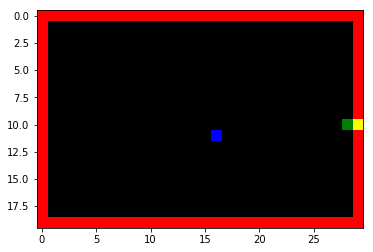

In [34]:
nibbles.reset()
game_over = False
while not game_over:
    if np.random.rand() < epsilon:
        action_index = random.randint(0,3)
    else: 
        q = np.squeeze(model.predict(np.expand_dims(nibbles.get_board(), axis=0)))
        action_index = sorted(range(4), key=lambda x: q[x])[-1]

    last_state = nibbles.get_board()

    revard, game_over = nibbles.next(nibbles.list_actions()[action_index])

    display.clear_output(wait=True)
    plt.imshow(nibbles.get_board())
    plt.show()   

In [17]:
radius

8

In [18]:
epsilon

0.1539474354692119